In [10]:
import numpy as np
from itertools import islice
import random
from collections import Counter
import matplotlib.pyplot as plt
import gzip, time, gc
from multiprocessing import Pool

### Read config.json file

In [15]:
import json
with open("config.json") as json_file:
    parameter = json.load(json_file)


print "BARCODE FILES:\n"
brc_dirs=[]
for i in range(len(parameter["barcode_filenames"])):
    brc_dirs+=[str(parameter["BASE_DIR"])+str(parameter["barcode_filenames"][i])]
    print brc_dirs[i]
random.seed()

BARCODE FILES:

/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-ACGCGGAA_lane-001-chunk-001.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-ACGCGGAA_lane-002-chunk-000.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-CGCTATCC_lane-001-chunk-001.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-CGCTATCC_lane-002-chunk-000.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-GTTGCATG_lane-001-chunk-001.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-GTTGCATG_lane-002-chunk-000.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-TAAATCGT_lane-001-chunk-001.fastq.gz
/home/vasilis/clustering_EQ/SC/pbmcs/pbmc3k_fastqs/read-I1_si-TAAATCGT_lane-002-chunk-000.fastq.gz


### Read barcodes

In [12]:
def encoding_map(ch):
    if ch=='A':return 0
    if ch=='G':return 1
    if ch=='C':return 2
    if ch=='T':return 3
    if ch=='N':return random.randint(0,3)

decoding_lst = ['A', 'G', 'C', 'T']

def encode(k):
    code = 0
    for ch in k:
        code *= 4
        code += encoding_map(ch)
    return code

def decode(code):
    ret = ''
    for _ in range(14):
        index = code & 3
        code >>= 2
        ret = decoding_lst[index] + ret
    return ret

def read_barcodes(brc_dir):
    barcodes=[]
    with gzip.open(brc_dir) as f:
        for barcode in list(islice(f, 1, None, 4)):
            barcodes+=[encode(barcode[:-1])]  # remove endline character
    return barcodes

def hamdist(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
######################################################

p=Pool()
t0 = time.time()
barcode_vec=p.map(read_barcodes, [brc_dirs[0],brc_dirs[1],brc_dirs[2],brc_dirs[3],brc_dirs[4],brc_dirs[5],brc_dirs[6],brc_dirs[7]] )
p.close()
p.join()

barcodes=np.array(barcode_vec[0]+barcode_vec[1]+barcode_vec[2]+barcode_vec[3]+barcode_vec[4]+
                  barcode_vec[5]+barcode_vec[6]+barcode_vec[7],dtype='uint32')
del barcode_vec[:];del barcode_vec
_ = gc.collect()

t1 = time.time()
print t1-t0, "sec"

print "Barcodes:\n"
for bar in barcodes[:10]:
       print decode(bar)
print "..."
NUMBER_OF_SEQUENCED_BARCODES=len(barcodes)
print "NUMBER_OF_SEQUENCED_BARCODES =",NUMBER_OF_SEQUENCED_BARCODES

323.125944853 sec
Barcodes:

AATCTCTGCTTTAC
ACCCAGCTTGCTTT
AATGCGCTCAGATC
ACGAACTGGCTATG
TGAGCTGACTGGAT
GGACCTCTTTTCTG
ACTAAAACTCGACA
CTATAGCTTCGCTC
ACCACGCTACAGCT
AGTATCCTAGAACA
...
NUMBER_OF_SEQUENCED_READS = 185980783


### UMI counts per barcode

NUM_OF_DISTINCT_BARCODES = 3831597


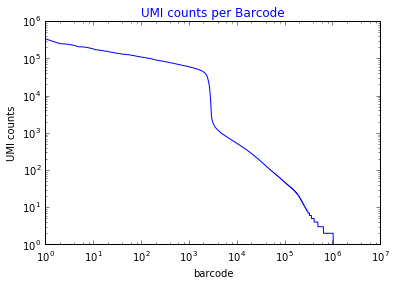

In [13]:
%matplotlib inline
counts = Counter(barcodes)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indices = np.arange(len(labels))


fig, ax = plt.subplots()
ax.plot(indices, (values))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('UMI counts', color='k')
ax.set_xlabel('barcode', color='k')
ax.set_title('UMI counts per Barcode', color='b')
#######
NUM_OF_DISTINCT_BARCODES=len(indices)
print "NUM_OF_DISTINCT_BARCODES =",NUM_OF_DISTINCT_BARCODES
#######

### Detect cell barcodes

Cell_barcodes_detected: 2704
NUM_OF_READS_in_CELL_BARCODES = 156302051


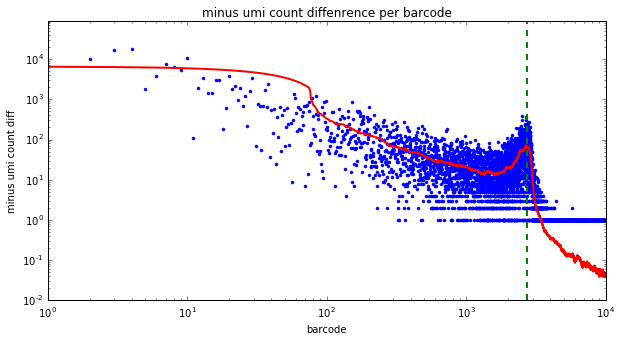

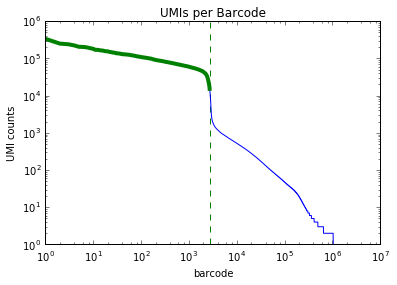

In [16]:
# By default we look for a number of cells in a window of 500 to 5000. 
# WINDOW = [500,5000]
WINDOW=parameter["WINDOW"]

from scipy.signal import savgol_filter as savgol
valdiff=np.diff((values))
yhat = savgol(valdiff, 151, 1)

fig, ax = plt.subplots(figsize=(10,5))
ax2=ax
ax2.plot(indices[:-1], (-valdiff),".b")
ax.plot(-(yhat),'r',linewidth=2.0)
ax.set_xlim([1,10000])
ax.set_ylim([0.01,-np.min(valdiff)])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel('minus umi count diff', color='k')
ax.set_xlabel('barcode', color='k')
ax.set_title('minus umi count diffenrence per barcode', color='k')

NUM_OF_BARCODES=np.argmax(-yhat[WINDOW[0]:WINDOW[1]])+WINDOW[0]
print "Cell_barcodes_detected:",NUM_OF_BARCODES

ax.axvline(NUM_OF_BARCODES, color='g', linestyle='--',linewidth=2.0)

NUM_OF_READS_in_CELL_BARCODES = sum(values[:NUM_OF_BARCODES])
print "NUM_OF_READS_in_CELL_BARCODES =",NUM_OF_READS_in_CELL_BARCODES


fig, ax2 = plt.subplots()
ax2.axvline(NUM_OF_BARCODES, color='g', linestyle='--',linewidth=1.0)
ax2.plot(indices, (values))
ax2.plot(indices[:NUM_OF_BARCODES], (values[:NUM_OF_BARCODES]),color='g', linestyle='-',linewidth=4.0)
ax2.set_xscale("log", nonposx='clip')
ax2.set_yscale("log", nonposy='clip')
ax2.set_ylabel('UMI counts', color='k')
ax2.set_xlabel('barcode', color='k')
ax2.set_title('UMIs per Barcode', color='k')

### Choose barcodes for error-correction

85.5483419895 sec
number of cell barcodes to error-correct: 111 ( dmin >= 5 )


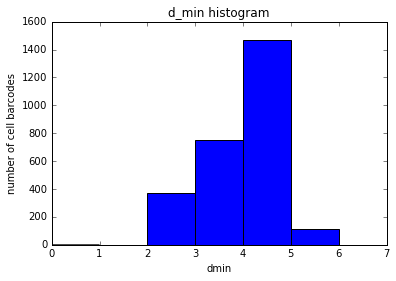

In [17]:
codewords=labels[:NUM_OF_BARCODES]
t0 = time.time()


Ham_dist=np.zeros([len(codewords),len(codewords)])
for i in range(len(codewords)):
    codi=decode(codewords[i])
    for j in range(i+1,len(codewords)):
        Ham_dist[i,j]=hamdist(codi,decode(codewords[j]))
        Ham_dist[j,i]=Ham_dist[i,j]
dmin=(Ham_dist+14*np.identity(len(codewords))).min(axis=1)

t1 = time.time()
print t1-t0, "sec"

fig, ax = plt.subplots()
ax.hist(dmin,range(8))
ax.set_ylabel('number of cell barcodes', color='k')
ax.set_xlabel('dmin', color='k')
ax.set_title('d_min histogram', color='k')

### to be on the safe side correct only barcodes that have d_min>=5
d=parameter['dmin']
brc_idx_to_correct=np.arange(len(codewords))[dmin>=d]
print "number of cell barcodes to error-correct:", len(brc_idx_to_correct), "( dmin >=", d,")"

In [18]:
## CLEANUP
del indices; del labels; del values; del counts; del valdiff; del indSort; del Ham_dist; del dmin
_ = gc.collect()

### Write output

In [19]:
import pickle

save_dir=str(parameter["SAVE_DIR"])
#create output directory 

import os
if not os.path.isdir(save_dir):
    try:
        os.mkdir(save_dir)
    except OSError as e:
        print "OSError({0}): {1}".format(e.errno, e.strerror)

t0 = time.time()
with open(save_dir+"barcodes.dat", 'wb') as f:
    pickle.dump(barcodes,f)
with open(save_dir+"codewords.dat", 'wb') as f:
    pickle.dump(codewords,f)
with open(save_dir+"brc_idx_to_correct.dat", 'wb') as f:
    pickle.dump(brc_idx_to_correct,f)
printer=""
printer+="NUMBER_OF_SEQUENCED_BARCODES: %s\n" % NUMBER_OF_SEQUENCED_BARCODES
printer+="NUM_OF_DISTINCT_BARCODES: %s\n" % NUM_OF_DISTINCT_BARCODES   
printer+="Cell_barcodes_detected: %s\n" % NUM_OF_BARCODES
printer+="NUM_OF_READS_in_CELL_BARCODES: %s\n" % NUM_OF_READS_in_CELL_BARCODES
printer+="NUM_OF_CELL_BARCODES_to_CORRECT %s (dmin >=%s)\n" % (len(brc_idx_to_correct), d)    
with open(save_dir+"run.info", 'wb') as f:
    f.write(printer)
print printer
t1 = time.time()
print t1-t0, "sec"
print "DONE."

49.5744559765 sec
DONE.
